In [1]:
import numpy as np
import pandas as pd
import math, datetime
import matplotlib.pyplot as plt

In [2]:
retail_df_origin = pd.read_excel(io='/content/drive/MyDrive/ml-data/Human-Activity-Recognition/Online Retail.xlsx')

In [3]:
retail_df = retail_df_origin
retail_df.head(5)
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
print(retail_df.isnull().sum())

(397884, 8)
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [5]:
retail_df = retail_df[retail_df['Country'] == 'United Kingdom']
print(retail_df.shape)

(354321, 8)


In [6]:
# Use RFM (Recency, Frequency, Monetary Value)

In [7]:
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [8]:
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


In [9]:
aggregations ={
    'InvoiceDate': 'max',
    'InvoiceNo':'count',
    'sale_amount': 'sum',
}

cust_df = retail_df.groupby('CustomerID').agg(aggregations)
cust_df = cust_df.rename(columns={
    'InvoiceDate':'Recency',
    'InvoiceNo':'Frequency',
    'sale_amount':'Monetary'
})

In [10]:
print(cust_df.head(5))
cust_df = cust_df.reset_index()
print(cust_df.head(5))

                       Recency  Frequency  Monetary
CustomerID                                         
12346      2011-01-18 10:01:00          1  77183.60
12747      2011-12-07 14:34:00        103   4196.01
12748      2011-12-09 12:20:00       4595  33719.73
12749      2011-12-06 09:56:00        199   4090.88
12820      2011-12-06 15:12:00         59    942.34
   CustomerID             Recency  Frequency  Monetary
0       12346 2011-01-18 10:01:00          1  77183.60
1       12747 2011-12-07 14:34:00        103   4196.01
2       12748 2011-12-09 12:20:00       4595  33719.73
3       12749 2011-12-06 09:56:00        199   4090.88
4       12820 2011-12-06 15:12:00         59    942.34


In [11]:
import datetime

cust_df['Recency'] = datetime.datetime(2011, 12, 10) - cust_df['Recency']
print(type(cust_df['Recency'][0]))
cust_df['Recency'] = cust_df['Recency'].apply(lambda x : x.days+1)
print(cust_df.shape)
print(cust_df.head(5))

<class 'pandas._libs.tslibs.timedeltas.Timedelta'>
(3920, 4)
   CustomerID  Recency  Frequency  Monetary
0       12346      326          1  77183.60
1       12747        3        103   4196.01
2       12748        1       4595  33719.73
3       12749        4        199   4090.88
4       12820        4         59    942.34


(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <a list of 10 Patch objects>)

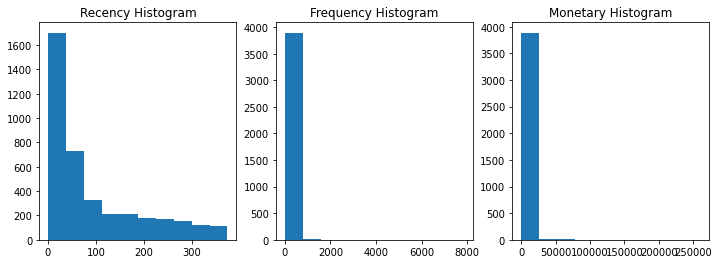

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

In [13]:
cust_df.describe()

,CustomerID,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000,3920.000000
mean,15562.059694,92.742092,90.388010,1864.385601
std,1576.594671,99.533485,217.808385,7482.817477
min,12346.000000,1.000000,1.000000,3.750000
25%,14208.750000,18.000000,17.000000,300.280000
50%,15569.500000,51.000000,41.000000,652.280000
75%,16913.250000,143.000000,99.250000,1576.585000
max,18287.000000,374.000000,7847.000000,259657.300000


In [14]:
markers=['o', 's', '^', 'x', '*', 'v', '<', '>', 'X']

In [15]:
def visualize_silhouette(cluster_lists, X_features, model=None): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.mixture import GaussianMixture
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math


    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        if model is not None and model == "gmm":
          clusterer = GaussianMixture(n_components=n_cluster, n_init=10, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features, model=None):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    print(pca.components_)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])

    ret = None 
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        if model is not None and model == "gmm":
          clusterer = GaussianMixture(n_components=n_cluster, n_init=10, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(cluster_labels)
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
        if n_cluster == 3:
          ret = clusterer
    plt.show()
    return ret

In [16]:
def PCAPlotData2(X_features, labels, model=None):
    # clusterer = KMeans(n_clusters = 2, max_iter=500, random_state=0)
    # if model is not None and model == "gmm":
    #   clusterer = GaussianMixture(n_components=3, n_init=10, max_iter=500, random_state=0)
    # cluster_labels = clusterer.fit_predict(pca_transformed)
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
    cluster_labels = labels
    dataframe['cluster']=cluster_labels
    
    unique_labels = np.unique(cluster_labels)

    plt.figure(figsize=(8,8)) 
    # 클러스터링 결과값 별로 scatter plot 으로 시각화
    for label in unique_labels:
        label_df = dataframe[dataframe['cluster']==label]
        if label == -1:
            cluster_legend = 'Noise'
        else :
            cluster_legend = 'Cluster '+str(label)           
        plt.scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
    plt.show()

In [17]:
def PCAPlotData(X_features, labels, do_pca=True):
  from sklearn.decomposition import PCA

  pca_transformed = X_features
  if do_pca == True:
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    print(pca.components_)
  labels = labels.reshape(-1, 1)
  dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
  dataframe['cluster']=labels
  unique_labels = np.unique(labels)
  plt.figure()
  for i, label in enumerate(unique_labels):
    cur_targets = dataframe[dataframe['cluster'] == label]
    plt.scatter(x=cur_targets['PCA1'], y=cur_targets['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label],)

### using KMeans

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

In [19]:
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['kmeans_label'] = labels

In [20]:
print(silhouette_score(X_features_scaled, labels))

0.5923691942714455


In [21]:
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

X_features = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)

[[-0.51257522  0.60727955  0.60702405]
 [-0.85864088 -0.36122064 -0.36366948]]


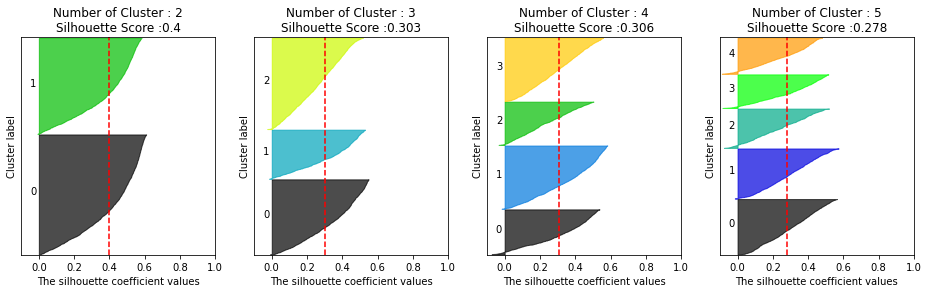

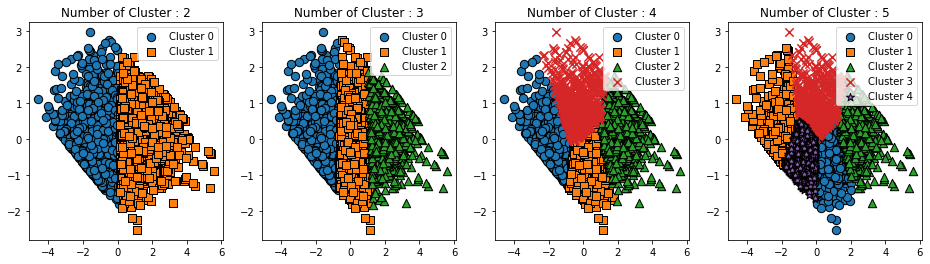

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [22]:
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)

###using MeanShift

In [23]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X_features_scaled)
print(bandwidth)

1.5594145725988002


In [24]:
from sklearn.cluster import MeanShift
meanshift = MeanShift(bandwidth=1.3).fit_predict(X_features_scaled)

In [25]:
pd.DataFrame(meanshift).value_counts()

0    3793
2      75
3      40
1      12
dtype: int64

[[-0.51257522  0.60727955  0.60702405]
 [-0.85864088 -0.36122064 -0.36366948]]


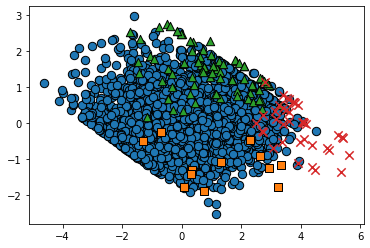

In [26]:
PCAPlotData(X_features_scaled, meanshift)

###using GaussianMixture

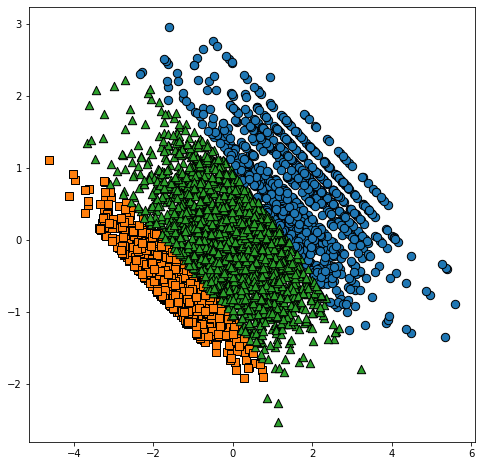

In [28]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
X_features_scaled_pca = PCA(n_components=2).fit_transform(X_features_scaled)
gmm = GaussianMixture(n_components=3, n_init=10, max_iter=500, random_state=0).fit(X_features_scaled_pca)
gmm_cluster_labels = gmm.predict(X_features_scaled_pca)

PCAPlotData2(X_features_scaled_pca, gmm_cluster_labels, model="gmm")

[0 1 2]


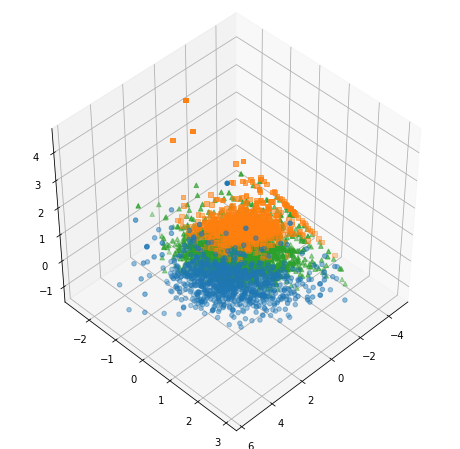

In [33]:
from matplotlib import interactive
%matplotlib inline
interactive(True)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
pca = PCA(n_components=3)
X_features_scaled_pca2 = pca.fit_transform(X_features_scaled)
gmm_cluster_labels2 = gmm_cluster_labels.reshape(-1, 1)
targets = pd.DataFrame(np.concatenate([X_features_scaled_pca2, gmm_cluster_labels2], axis=1), columns=['ftr1', 'ftr2', 'ftr3', 'label'])
label_types = np.unique(gmm_cluster_labels2)
print(label_types)


markers=['o', 's', '^', 'x', '*']
for i, label in enumerate(label_types):
  cur_targets = targets[targets['label'] == label]
  ax.scatter(cur_targets['ftr1'], cur_targets['ftr2'], cur_targets['ftr3'], marker=markers[i])
ax.view_init(45, 45)

[[-0.51257522  0.60727955  0.60702405]
 [-0.85864088 -0.36122064 -0.36366948]]


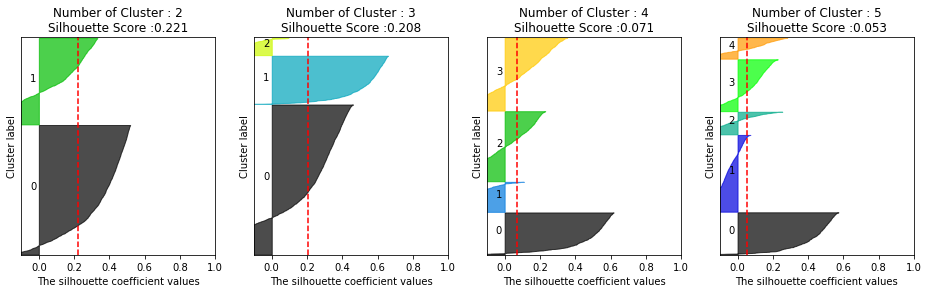

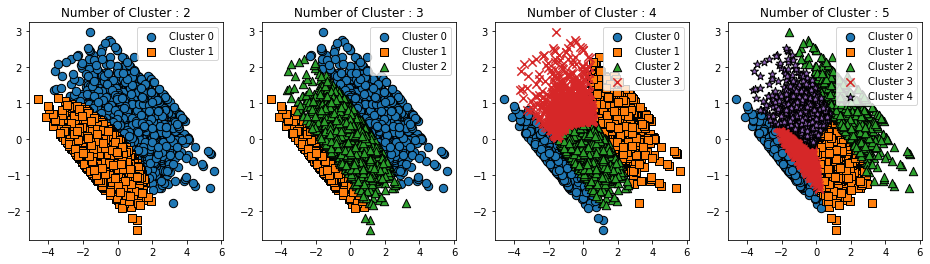

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=500,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=0, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [34]:
visualize_silhouette([2,3,4,5], X_features_scaled, model="gmm")
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled, model="gmm")

###using DBSCAN

[[ 0.07917206 -1.78084635]
 [ 2.29034727  0.83294819]
 [ 5.40555421 -0.40690883]
 ...
 [-0.57001237  1.81853142]
 [ 2.82051071  0.32026529]
 [ 0.76233601 -0.39257198]]
eps: 0.25, min_samples: 10


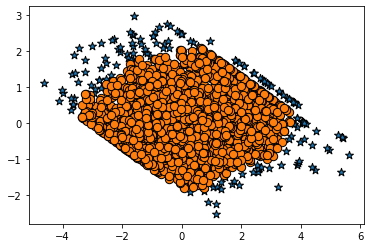

eps: 0.25, min_samples: 50


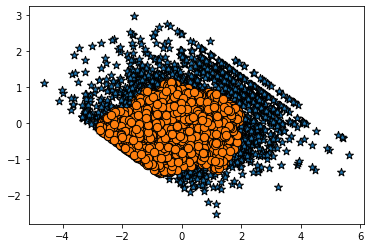

eps: 0.25, min_samples: 100


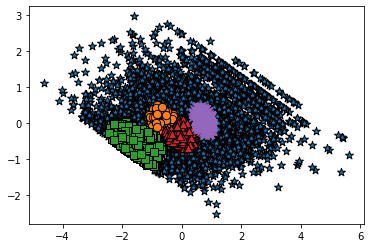

eps: 0.25, min_samples: 150


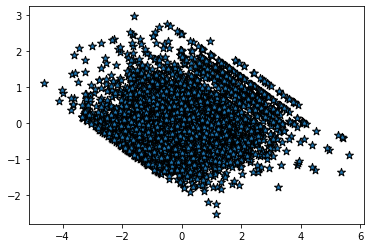

eps: 0.5, min_samples: 10


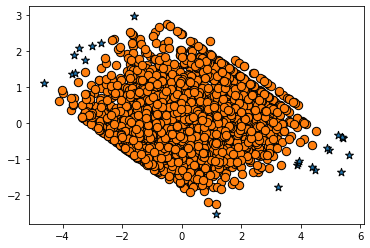

eps: 0.5, min_samples: 50


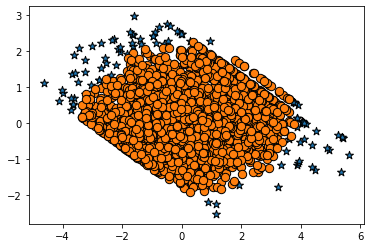

eps: 0.5, min_samples: 100


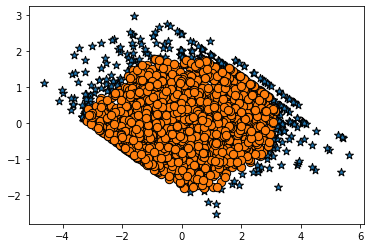

eps: 0.5, min_samples: 150


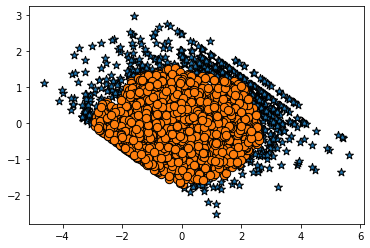

eps: 0.75, min_samples: 10


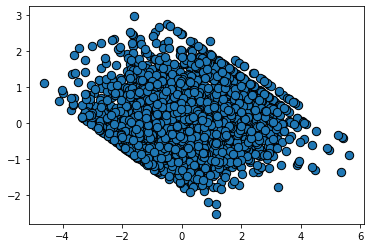

eps: 0.75, min_samples: 50


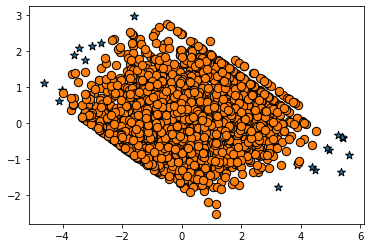

eps: 0.75, min_samples: 100


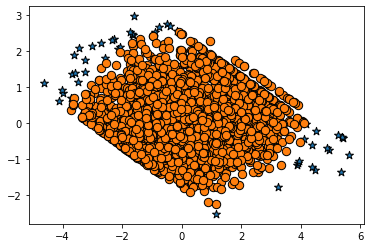

eps: 0.75, min_samples: 150


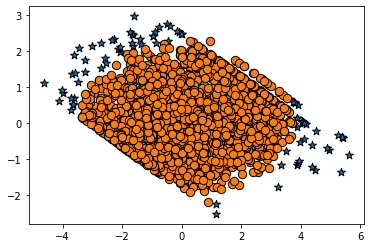

In [36]:
from sklearn.cluster import DBSCAN

print(X_features_scaled_pca)
#about eps
for i in [0.25, 0.5, 0.75]:
  for j in [10, 50, 100, 150]:
    print("eps: {0}, min_samples: {1}".format(i, j))
    dbscan = DBSCAN(eps=i, min_samples=j, metric='euclidean')
    dbscan_labels = dbscan.fit_predict(X_features_scaled_pca)
    PCAPlotData(X_features_scaled_pca, dbscan_labels, do_pca=False)
    plt.show()